In [39]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.graph_objects as go
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


import warnings

In [40]:
# Omitir FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [41]:
directorio = '../data'

df_original = pd.read_excel(os.path.join(directorio,"dieta_oscar_MCD.xlsx"), index_col=0)

df_original.head()

,edad,sexo,estado,peso total,Oxalis,Quercus,Cyp.bulb,Phaseolus,Tephoria,Caracoles,...,covey,dist camino,ppanual17,tmedia17,altitud,lat,lon,hcrop,hland,gap
id,,,,,,,,,,,,,,,,,,,,,
2014-104,J,Female,NM,9.7584,9.7584,0.0,0.000,0.0000,0.0000,0.0,...,6.0,251.86,462.0,7.054167,2518.0,34.037969,-108.963777,0.000000,0.798600,Rocky Mountain Ponderosa Pine Woodland
2014-105,J,Male,NM,3.9632,3.9632,0.0,0.000,0.0000,0.0000,0.0,...,6.0,251.86,462.0,7.054167,2518.0,34.037969,-108.963777,0.000000,0.798600,Rocky Mountain Ponderosa Pine Woodland
2016-133,A,Female,AZ,5.4562,3.8238,0.0,0.000,0.6148,0.0726,0.0,...,10.0,574.06,515.0,15.954167,1527.0,31.375725,-110.530491,0.785803,1.245916,Madrean Encinal
2014-28,J,Female,NM,4.4976,3.7076,0.0,0.000,0.0000,0.0000,0.0,...,8.0,23.07,385.0,10.979167,1952.0,33.176791,-107.735593,0.464732,0.764466,Colorado Plateau Pinyon-Juniper Woodland
2016-132,J,Male,AZ,5.4630,2.2011,0.0,0.778,0.3908,0.0000,0.0,...,8.0,236.76,521.0,16.133333,1507.0,31.353053,-110.531060,1.680150,1.541562,Apacherian-Chihuahuan Mesquite Upland Scrub


In [42]:
print(df_original.columns)

Index(['edad', 'sexo', 'estado', 'peso total', 'Oxalis', 'Quercus', 'Cyp.bulb',
       'Phaseolus', 'Tephoria', 'Caracoles',
       ...
       'covey', 'dist camino', 'ppanual17', 'tmedia17', 'altitud', 'lat',
       'lon', 'hcrop', 'hland', 'gap'],
      dtype='object', length=145)


In [43]:
df_original.shape

(319, 145)

Eliminamos los registros donde ambas columnas 'sexo' y 'edad' tienen valores nulos, esto para ir descartando registros que no aporten a nuestro modelo estadistico por falta de información.

In [44]:
df = df_original.dropna(subset=['edad', 'sexo'], how='all')

In [45]:
df.shape

(277, 145)

In [46]:
null_columns = df.columns[df.isnull().sum() > 0]
print(df[null_columns].isnull().sum())

edad              45
Quercus            1
Cyp.bulb           2
Lotus.wrightii     1
Fabacea            1
SP34               1
SPA33              1
SPA55              2
time              46
covey             87
dist camino       56
ppanual17         56
tmedia17          56
altitud           56
lat               56
lon               56
hland             57
gap               56
dtype: int64


Mostramos una grafica de como se distribuye el peso total entre los distintos sexos.

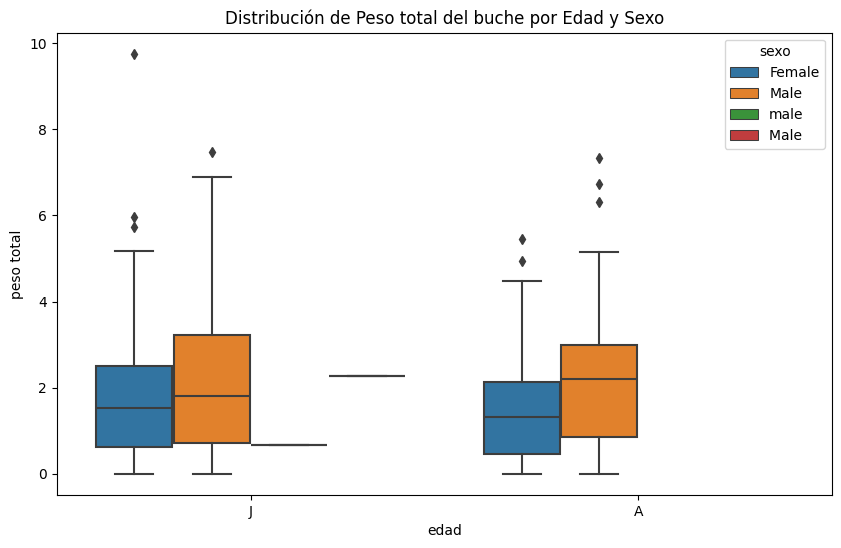

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='edad', y='peso total', hue='sexo', data=df)
plt.title('Distribución de Peso total del buche por Edad y Sexo')
plt.show()

Aplicaremos una serie de pasos, que nos permitira realizar imputación a la variable sexo, asi con eso apoyar en encontrar un valor adecuado para los datos faltantes en esta variable

In [48]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
    df['sexo'].fillna('Desconocido', inplace=True)

In [49]:
df_sexo_known = df[df['sexo'] != 'Desconocido']
df_sexo_unknown = df[df['sexo'] == 'Desconocido']

In [50]:
X = df_sexo_known[['peso total', 'estado']]
y = df_sexo_known['sexo']

Usamos regresión logistica, para encontrar el sexo, esto a partir del peso y el estado para encontrar la relación y por lo tanto estimar si puede pertenecer a un macho o hembra.

In [51]:
if not df_sexo_unknown.empty:
    X = pd.get_dummies(X)

    feature_names = X.columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_sexo = LogisticRegression()
    model_sexo.fit(X_train, y_train)

    X_sexo_unknown = pd.get_dummies(df_sexo_unknown[['peso total', 'estado']])

    X_sexo_unknown = X_sexo_unknown.reindex(columns=feature_names, fill_value=0)

    predicted_sex = model_sexo.predict(X_sexo_unknown)

    df.loc[df['sexo'] == 'Desconocido', 'sexo'] = predicted_sex

In [52]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
    df['sexo'] = df['sexo'].str.lower()
    df['sexo'] = df['sexo'].apply(lambda x: 'Female' if re.search(r'female', x) else 'Male' if re.search(r'male', x) else None)
    df = df.dropna(subset=['sexo'])

Aplicaremos una serie de pasos, que nos permitira realizar imputación a la variable edad, asi con eso apoyar en encontrar un valor adecuado para los datos faltantes en esta variable

In [53]:
known_age_df = df[df['edad'].notnull()]
unknown_age_df = df[df['edad'].isnull()]

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

    known_age_df['edad'] = known_age_df['edad'].map({'J': 0, 'A': 1})

    X_known = known_age_df[['sexo', 'peso total']]
    X_known = pd.get_dummies(X_known, drop_first=True)
    y_known = known_age_df['edad']

    X_unknown = unknown_age_df[['sexo', 'peso total']]
    X_unknown = pd.get_dummies(X_unknown, drop_first=True) 

In [55]:
X_unknown = X_unknown.reindex(columns=X_known.columns, fill_value=0)

Usamos regresión logistica, para encontrar la edad, esto a partir del peso y el sexo para encontrar la relación y por lo tanto estimar si puede pertenecer a un adulto o joven.

In [56]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

    logreg = LogisticRegression()
    logreg.fit(X_known, y_known)

    predicted_ages = logreg.predict(X_unknown)

    unknown_age_df['edad'] = predicted_ages

    unknown_age_df['edad'] = unknown_age_df['edad'].map({0: 'J', 1: 'A'})

In [57]:
df.update(unknown_age_df)

In [58]:
df['edad'] = df['edad'].str.lower()
df['edad'] = df['edad'].apply(lambda x: 'J' if re.search(r'j', x) else 'A' if re.search(r'a', x) else None)
df = df.dropna(subset=['edad'])

In [59]:
null_columns = df.columns[df.isnull().sum() > 0]
print(df[null_columns].isnull().sum())

Quercus            1
Cyp.bulb           2
Lotus.wrightii     1
Fabacea            1
SP34               1
SPA33              1
SPA55              2
time              46
covey             87
dist camino       56
ppanual17         56
tmedia17          56
altitud           56
lat               56
lon               56
hland             57
gap               56
dtype: int64


Mostramos otra vez la grafica de como se distribuye el peso total entre los distintos sexos, despues de haber realizado un proceso de depuración de los datos.

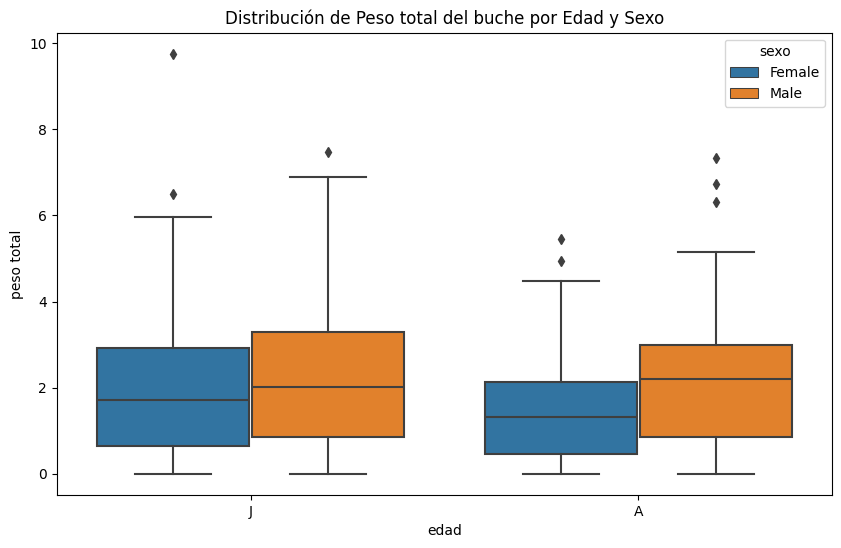

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='edad', y='peso total', hue='sexo', data=df)
plt.title('Distribución de Peso total del buche por Edad y Sexo')
plt.show()

Ponemos en 0 los nulos o vacios en los datos de la dieta.

In [61]:
null_columns = ['Quercus', 'Cyp.bulb', 'Lotus.wrightii', 'Fabacea', 'SP34', 'SPA33', 'SPA55', 'Bothriochloa.1']
df[null_columns] = df[null_columns].fillna(0)

In [62]:
null_columns = df.columns[df.isnull().sum() > 0]
print(df[null_columns].isnull().sum())

time           46
covey          87
dist camino    56
ppanual17      56
tmedia17       56
altitud        56
lat            56
lon            56
hland          57
gap            56
dtype: int64


Ahora haremos imputación de datos de la variable time, para que tome un promedio de las ultimos 10 registros a partir de ordenar el id.

In [63]:
# Ordena el DataFrame por el ID, lo que efectivamente ordenará por año y número
df.sort_values(by='id', inplace=True)

In [64]:
df['time'] = df['time'].astype(str)

# Función para convertir los valores de tiempo en minutos
def time_to_minutes(time_str):
    hour = int(time_str[:2])
    minute = int(time_str[2:])
    return hour * 60 + minute

# Función para calcular el promedio de los últimos 10 registros no nulos
def calculate_average_last_10(index):
    # Extrayendo el número del índice y conviértelo a un entero
    index_number = int(index.split('-')[1])
    # Seleccionando las últimas 10 filas y filtra aquellas con valores de tiempo no nulos
    last_10 = df.iloc[max(0, index_number - 10):index_number]
    last_10 = last_10[last_10['time'].notnull()]
    # Si hay al menos una fila no nula en las últimas 10 filas, calcula el promedio
    if not last_10.empty:
        return last_10['time'].apply(time_to_minutes).mean()
    else:
        return None

# Iterando sobre las filas y rellena los valores nulos en 'time' con el promedio de los últimos 10 registros no nulos
for index, row in df.iterrows():
    if pd.isnull(row['time']):
        average_last_10 = calculate_average_last_10(index)
        if average_last_10 is not None:
            hours = int(average_last_10 / 60)
            minutes = int(average_last_10 % 60)
            df.at[index, 'time'] = f"{hours:02d}{minutes:02d}"

In [65]:
null_columns = df.columns[df.isnull().sum() > 0]
print(df[null_columns].isnull().sum())

covey          87
dist camino    56
ppanual17      56
tmedia17       56
altitud        56
lat            56
lon            56
hland          57
gap            56
dtype: int64


Inputamos los datos de la variable covey poniendo 1 a los valores nulos, pues seria como avistar solo uno sin un grupo.

In [66]:
# Ordenar el DataFrame por estado
#df.sort_values(by=['estado'], inplace=True)

# Función para calcular el promedio de los últimos n valores no nulos
#def calculate_average_last_n(group, current_index, n=10):
#    previous_values = group.loc[:current_index, 'covey'].dropna().tail(n)
#    if not previous_values.empty:
#        return previous_values.mean()
#    else:
#        return np.nan

# Iterar sobre las filas y rellenar los valores nulos en 'covey' con el promedio de los últimos valores no nulos del mismo estado
#for index, row in df.iterrows():
#    if pd.isnull(row['covey']):
#        estado = row['estado']
        
        # Filtrar el DataFrame para el mismo estado
#        same_state_group = df[df['estado'] == estado]
        
        # Calcular el promedio de los últimos 10 valores no nulos en 'covey'
#        average_covey = calculate_average_last_n(same_state_group, index, n=10)
        
#        if not np.isnan(average_covey):
#            df.at[index, 'covey'] = average_covey

# Opcional: Llenar cualquier valor nulo restante con una estrategia alternativa (e.g., promedio global, mediana, etc.)
#df['covey'].fillna(df['covey'].mean(), inplace=True)

df['covey'] = df['covey'].fillna(1)
df['covey'] = df['covey'].replace('', 1)
df['covey'] = df['covey'].replace(r'^\s*$', 1, regex=True)


In [67]:
null_columns = df.columns[df.isnull().sum() > 0]
print(df[null_columns].isnull().sum())

dist camino    56
ppanual17      56
tmedia17       56
altitud        56
lat            56
lon            56
hland          57
gap            56
dtype: int64


Realizamos la imputación de los datos de las variables lat , lon y altitud, basandonos en la variable estado, dependiendo del promedio de los ultimos 10 datos registrados y asi obtener un valor aproximado.

In [68]:
# Ordenar el DataFrame por estado
df.sort_values(by=['estado'], inplace=True)

# Función para calcular el promedio de los últimos n valores no nulos de una columna
def calculate_average_last_n(group, column, current_index, n=10):
    previous_values = group.loc[:current_index, column].dropna().tail(n)
    if not previous_values.empty:
        return previous_values.mean()
    else:
        return np.nan

# Iterar sobre las filas y rellenar los valores nulos en 'lat', 'lon' y 'altitud' con el promedio de los últimos valores no nulos del mismo estado
for index, row in df.iterrows():
    estado = row['estado']
    same_state_group = df[df['estado'] == estado]
    
    # Rellenar valores nulos en 'lat'
    if pd.isnull(row['lat']):
        average_lat = calculate_average_last_n(same_state_group, 'lat', index, n=10)
        if not np.isnan(average_lat):
            df.at[index, 'lat'] = average_lat
    
    # Rellenar valores nulos en 'lon'
    if pd.isnull(row['lon']):
        average_lon = calculate_average_last_n(same_state_group, 'lon', index, n=10)
        if not np.isnan(average_lon):
            df.at[index, 'lon'] = average_lon
    
    # Rellenar valores nulos en 'altitud'
    if pd.isnull(row['altitud']):
        average_altitude = calculate_average_last_n(same_state_group, 'altitud', index, n=10)
        if not np.isnan(average_altitude):
            df.at[index, 'altitud'] = average_altitude

# Opcional: Llenar cualquier valor nulo restante con una estrategia alternativa (e.g., promedio global, mediana, etc.)
df['lat'].fillna(df['lat'].mean(), inplace=True)
df['lon'].fillna(df['lon'].mean(), inplace=True)
df['altitud'].fillna(df['altitud'].mean(), inplace=True)

In [69]:
null_columns = df.columns[df.isnull().sum() > 0]
print(df[null_columns].isnull().sum())

dist camino    56
ppanual17      56
tmedia17       56
hland          57
gap            56
dtype: int64


Realizamos una de las ultima imputaciones de datos usando el metodo ffill para obtener valores de la columna previa.

In [70]:
df.fillna(method='ffill', inplace=True)

In [71]:
null_columns = df.columns[df.isnull().sum() > 0]
print(df[null_columns].isnull().sum())
print(df.shape)

dist camino    1
ppanual17      1
tmedia17       1
hland          1
gap            1
dtype: int64
(277, 145)


Realizamos la eliminación de registros donde en las tres variables mostradas abajo tienden a ser nulos, para evitar agregarla a nuestro analisis si no cuentan con estos datos.

In [72]:
df = df.dropna(subset=['ppanual17', 'tmedia17', 'gap'], how='all')

In [73]:
print(df.shape)

(276, 145)


In [74]:
df['estado'] = df['estado'].str.upper()

Realizamos las ultimas transformaciones de los datos para ayudar con el analisis estadistico.

In [75]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

    #Empecemos convirierndo variables categoricas a numéricas
    df['Adulto'] = df['edad'].map({'J': 0, 'A': 1})
    df['Male'] = df['sexo'].map({'Female': 0, 'Male': 1})
    df = pd.get_dummies(df, columns=['estado', 'gap'])

    df.drop(['edad', 'sexo'], axis=1, inplace=True)

    #Procederemos a normalizar los pesos de alimentos.
    from sklearn.preprocessing import StandardScaler

    #Seleccionando las columnas de la dieta con los pesos.
    columns_pesos = df.columns[df.columns.get_loc("Oxalis"):df.columns.get_loc("Juniperus prob. deppeana") + 1]
    scaler = StandardScaler()
    df[columns_pesos] = scaler.fit_transform(df[columns_pesos])

    df.head()

In [76]:
df['covey'] = df['covey'].fillna(1)
df['covey'] = df['covey'].replace('', 1)
df['covey'] = df['covey'].replace(r'^\s*$', 1, regex=True)

In [77]:
null_columns = df.columns[df.isnull().sum() > 0]
print(df[null_columns].isnull().sum())
print(df.shape)

Series([], dtype: float64)
(276, 159)


In [78]:
df.to_csv('../data/data_procesada.csv', index=False)